**Strand breaks** 
TODO NOTES  
Date time incorrect, need a second one to work out new date_time and time taken for calculations, used later speed distance time and whatnot.

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import yaml
from scipy.special import factorial
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [43]:
def open_yaml(yaml_file):
    with open(yaml_file, 'r') as stream:
        try:
            return yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

            
def print_yaml(yaml_file):
    yaml_content = open_yaml(yaml_file)
    dictionary = yaml_content
    for key, value in dictionary.items():
        print(key, value)
        
    
yaml_file = 'comments_for_next_session.yaml'
print_yaml(yaml_file)   

Date and user 
16th November, week 1 session 2, user DD

General comments 
I have renamed variables so they read clearly from an outside perspective and to avoid getting confused. I have created a yaml file outlining the new variable names and purposes to reduce the number of comments in file. I have done the same for new functions. I have employed functional programming techniques throughout the code with varying success!

Simulation of strand length 
I have fixed the issue with sci py special.factorial. We need to use 'from scipy.special import factorial'
What is importance of date time?
Confused when it comes to the third histogram, why does this rely on length_strand instead of length_segment?
In main for loop what is num_hist_here, len_hist_here section? What does 'end' mean and do? 
Is there a better way we could write n_poiss_plot and k_poiss_plot? I do not understand what these variables mean.

DNA Clumping 
Attempted to employ functional programming techniques but struggling w

Outputting yaml file containing information on variables and functions used in this notebook.

In [38]:
yaml_file = 'variable_and_function_names.yaml'
print_yaml(yaml_file)   

Simulation of strand length 

VARIABLES
no_single_strands: Number of single DNA strands
length_strand: Length of DNA strand, this is a measurement of base pairs.
mean_breaks: Average number of breaks per strand.
no_breaks: number of breaks
no_segments: Number of segments generated after proton therapy has been applied and strands have been broken.
length_segment: Length of segments
k: Number of occurrances for poisson function
lam: Poisson function lambda

FUNCTIONS
date_time(): Returns date and time programme is run at
poisson_function(k, lam): Determines a poisson distribution from k number of occurrances and lam lambda, this is called in data_visualisation()
data_visualisation(mean_breaks, length_strand, length_segment): Data visualisation of number of breaks of dna strands and segment lengths

DNA Clumping 

VARIABLES
use_sphere:
radius_nucleus:
radius_nucleus_min:
sig_radius_nucleus:
radius_cell:
radius_cell_min:
sig_radius_cell:

FUNCTIONS
defining_parameters():
_2Dcell():
_3Dcel

**Develop simulation of strand length**  
Choose the actual number of breaks for a given strand using a Poisson distribution and the mean number of breaks per strand. Assume the breaks are uniformly distributed along each strand. Calculate the distance between breaks (the segment lengths) by sorting the breaks according to distance along the strand then subtracting successive break positions. Add the first and and last segment lengths (zero to first sorted break, last sorted break to strand length, respectively).  
**Questions to discuss at next meeting**  
Why are we using date time? Why do we need to work out now-then in final part?  
Why are we using length_strand for segment length histogram?

Date and time  2022-11-16 15:27:54.650480

Date and time 2022-11-16 15:27:54.761184
Time since last check is 0:00:00.110704


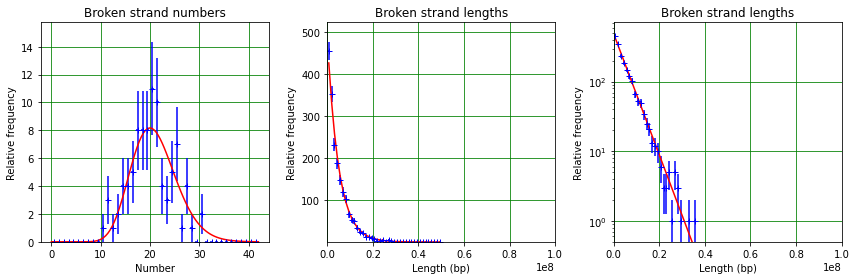

In [14]:
def poisson_function(k, lam):
    '''
    Poisson distribution function.
    Parameters: k number of occurances, lam lambda of the poisson function.
    Returns: distribution function value.
    '''
    poisson = lam**k*np.exp(-lam)/sp.special.factorial(k)
    return poisson


def data_visualisation(mean_breaks, length_strand, length_segment):
    '''
    Objective of this function is to create graphs to visualise the data.
    Parameters: mean_breaks used to display number of breaks, 
                length_strand used for segment length histogram,
                length_segment used for ???
    Returns: two histograms displaying the number of breaks and segment lengths
    '''
    # Set up histogram of number of breaks
    num_range = np.zeros(2)
    num_range[0] = np.maximum(mean_breaks - 5*np.sqrt(mean_breaks), 0.0).astype(int)
    num_range[1] = (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)
    n_num_bins = ((num_range[1] - num_range[0])).astype(int)
    num_bins, num_bin_wid = np.linspace(num_range[0], num_range[1], n_num_bins + 1, retstep = True)
    num_bin_cents = 0.5*(num_bins[0:n_num_bins] + num_bins[1:n_num_bins + 1])
    num_bin_err = num_bin_wid/np.sqrt(12)*np.ones(n_num_bins)
    cum_num_hist = np.zeros(n_num_bins)

    # Set up histogram of segment lengths
    n_len_bins = 40
    len_bins, len_bin_wid = np.linspace(0.0, 10*length_strand/mean_breaks, n_len_bins + 1, retstep = True)
    len_bin_cents = 0.5*(len_bins[0:n_len_bins] + len_bins[1:n_len_bins + 1])
    len_bin_err = len_bin_wid/np.sqrt(12)*np.ones(n_len_bins)
    cum_len_hist = np.zeros(n_len_bins)
    
    # setting up random number generator for breaking the strands
    rng = np.random.default_rng()
    
    for n in range(0, no_single_strands):
        # Simulate breaks and segments for each strand.
        # creating randomly generated number of breaks.
        no_breaks = rng.poisson(mean_breaks)
        breaks = np.zeros(no_breaks)
        # number of segments is number of breaks + 1
        no_segments[n] = no_breaks + 1
        # breaks randomly generated uniform distribution. Number of steps is number of breaks.
        breaks = rng.uniform(0.0, 1.0, no_breaks)
        # final segment? confused as to what this does and relevance.
        ends = np.zeros(no_segments[n] + 1)
        ends[1:no_segments[n]] = np.sort(breaks)
        ends[no_segments[n]] = 1.0
        # determines lengh of each individual segment based on length of unbroken strand and end. What does end mean?
        length_segment[n, 0:no_segments[n]] = length_strand*(ends[1:no_segments[n] + 1] - ends[0:no_segments[n]])    
        
        # what does this do?
        num_hist_here, _ = np.histogram(no_breaks, num_bins)
        cum_num_hist += num_hist_here 
        
        # what does this do?
        len_hist_here, _ = np.histogram(length_segment[n, 0:no_segments[n]], len_bins)
        cum_len_hist += len_hist_here
    
    n_poiss_plot = 100 # is this number of points to plot?
    k_poiss_plot = np.linspace(num_range[0], num_range[1], n_poiss_plot) # what does k stand for, clearer name?
    poiss_func_plot = no_single_strands*num_bin_wid*poisson_function(mean_breaks, k_poiss_plot) # num_bin_wid could be written more descriptively

    # Function describing segment length distribution. Can len variables be rewritten so meaning of 'wid' and 'cents' clearer, confused as to difference of this.
    len_func_plot = (mean_breaks*(mean_breaks + 1)*no_single_strands*
                    len_bin_wid/length_strand*np.exp(-mean_breaks*len_bin_cents/length_strand))

    fig, ax = plt.subplots(1, 3, figsize = (12, 4))

    # Graph for broken strand numbers
    ax[0].set_title('Broken strand numbers') # is there a better way we can describe this graph?
    ax[0].errorbar(num_bin_cents, cum_num_hist, xerr = num_bin_err, yerr = np.sqrt(cum_num_hist),
                    linestyle = '', marker = '+', color = 'b')
    ax[0].plot(k_poiss_plot, poiss_func_plot, linestyle = '-', marker = '', color = 'r')
    ax[0].set_xlabel('Number')
    ax[0].set_ylabel('Relative frequency')
    ax[0].set_ylim(0.0, 1.1*(np.amax(cum_num_hist) + np.amax(np.sqrt(cum_num_hist))))
    ax[0].grid(color = 'g')

    # Graph of broken strand lengths 
    ax[1].set_title('Broken strand lengths')
    ax[1].errorbar(len_bin_cents, cum_len_hist, xerr = len_bin_err, yerr = np.sqrt(cum_len_hist),
                    linestyle = '', marker = '+', color = 'b')
    ax[1].plot(len_bin_cents, len_func_plot, linestyle = '-', marker = '', color = 'r')
    ax[1].set_xlabel('Length (bp)')
    ax[1].set_ylabel('Relative frequency')
    ax[1].set_xlim(0.0, length_strand)
    ax[1].set_ylim(0.5, 1.1*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
    ax[1].grid(color = 'g')
    
    # struggling to see difference between this graph and graph above
    ax[2].set_title('Broken strand lengths')
    ax[2].errorbar(len_bin_cents, cum_len_hist, xerr = len_bin_err, yerr = np.sqrt(cum_len_hist),
                    linestyle = '', marker = '+', color = 'b')
    ax[2].plot(len_bin_cents, len_func_plot, linestyle = '-', marker = '', color = 'r')
    ax[2].set_xlabel('Length (bp)')
    ax[2].set_ylabel('Relative frequency')
    ax[2].set_xlim(0.0, length_strand)
    ax[2].set_ylim(0.5, 1.5*(np.amax(cum_len_hist) + np.amax(np.sqrt(cum_len_hist))))
    ax[2].set_yscale('log')
    ax[2].grid(color = 'g')

    plt.tight_layout()
    plt.show

    
# Defining main variables, details on these described in yaml function.
no_single_strands = 92
length_strand = 1e8 
mean_breaks = 20 
no_segments = np.zeros(no_single_strands).astype(int)
length_segment = np.zeros((no_single_strands, (mean_breaks + 5*np.sqrt(mean_breaks)).astype(int)))
    
# time before running function.   
now = datetime.datetime.now()
print("Date and time ",str(now))

# running function to return three graphs.
data_visualisation(mean_breaks, length_strand, length_segment)

# time after running function. Calculating time taken to run function.
then = now
now = datetime.datetime.now()
print("\nDate and time",str(now))
print("Time since last check is",str(now - then))

**DNA clumping**  
Chromosomes are coiled up into roughly spherical structures when not undergoing mitosis. The typical diameter of the sphere is about 3 to 4 \mum. Put one end of each strand inside a sphere of radius 2 \mum. (The breaks are assumed not to influence this intial structure!) Nuclear diameter about 20 \mum. See here for information on mouse nucleus!.


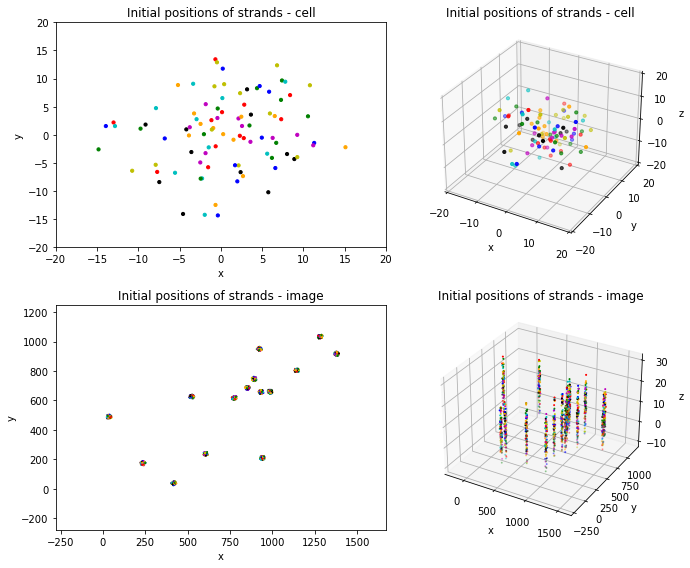

In [18]:
# TODO could this be written more efficiently using functions? I have tried but difficulty with returning/passing parameters?
# might be clearer if info for each graph is in the same place.
# use_sphere?
use_sphere = True

# Radius of nucleus microns
radius_nucleus = 2.0 
radius_nucleus_min = 1.5 
sig_radius_nucleus = 0.5 # what does sig stand for?

# Radius of cell microns
radius_cell = 10.0 
radius_cell_min = 16.0 
sig_radius_cell = 1.0 # sig?

# Color table for plots
n_color_tab = 8 # number of colours in use
color_tab = np.array(['r', 'orange', 'y', 'g', 'c', 'b', 'm', 'k'])

fig = plt.figure(figsize = (10, 8))

# 2D graph of strand positions in cell
ax2d_cell = fig.add_subplot(2, 2, 1)
ax2d_cell.set_title("Initial positions of strands - cell")
ax2d_cell.set_xlabel("x")
ax2d_cell.set_ylabel("y")

# 3D graph of strand positions in cell
ax3d_cell = fig.add_subplot(2, 2, 2, projection='3d')
ax3d_cell.set_title("Initial positions of strands - cell")
ax3d_cell.set_xlabel("x")
ax3d_cell.set_ylabel("y")
ax3d_cell.set_zlabel("z")

# 2D graph of strand positions in image - how does image vary from cell?
ax2d_pic = fig.add_subplot(2, 2, 3)
ax2d_pic.set_title("Initial positions of strands - image")
ax2d_pic.set_xlabel("x")
ax2d_pic.set_ylabel("y")

# 3D graph of strand positions in image
ax3d_pic = fig.add_subplot(2, 2, 4, projection='3d')
ax3d_pic.set_title("Initial positions of strands - image")
ax3d_pic.set_xlabel("x")
ax3d_pic.set_ylabel("y")
ax3d_pic.set_zlabel("z")

# Image dimensions of pixels. Rows y coordinate, columns, x coordinate, depth z coordinate.
n_rows = 1040 
n_columns = 1392 
depth = 20

# Set up number of cells and their positions
n_cells = 15
x_cell = np.zeros(n_cells)
y_cell = np.zeros(n_cells)
z_cell = np.zeros(n_cells)

# Set location of cells
if n_cells == 1:
    x_cell[0] = n_columns/2
    y_cell[0] = n_rows/2
    z_cell[0] = depth/2
else:
    x_cell = np.random.uniform(0, n_columns, n_cells)
    y_cell = np.random.uniform(0, n_rows, n_cells)
    z_cell = np.random.uniform(0, depth, n_cells)


# Colors for plotting strands
colors = np.zeros(no_single_strands).astype(str)

for n_cell in range(0, n_cells):
    # Simulate uniform radial and phi initial distribution of strands
    radius_array = np.sqrt(np.random.uniform(0, max(np.random.normal(radius_cell, sig_radius_cell, 1),
                                              radius_cell_min)**2, no_single_strands))
    phi_array = np.random.uniform(0, 2*np.pi, no_single_strands)
    
    # Determine initial x, y, z coordinates of strands (simulate uniform intial theta distribution if required)
    if use_sphere:
        theta_array = np.arccos(np.random.uniform(-1, 1, no_single_strands))
        x_array = x_cell[n_cell] + radius_array*np.sin(theta_array)*np.cos(phi_array)
        y_array = y_cell[n_cell] + radius_array*np.sin(theta_array)*np.sin(phi_array)
        z_array = z_cell[n_cell] + radius_array*np.cos(theta_array)
    else:
        x_array = x_cell[n_cell] + radius_array*np.cos(phi_array)
        y_array = y_cell[n_cell] + radius_array*np.sin(phi_array)
        z_array = x_cell[n_cell] + np.random.uniform(0, depth, no_single_strands)
    
    # Plot intial positions of all strands in image
    color_inds = (np.linspace(0, no_single_strands - 1, no_single_strands)%n_color_tab).astype(int) # ind - indices/index?
    ax2d_pic.scatter(x_array, y_array, color = color_tab[color_inds], s = 1.0)
    ax3d_pic.scatter(x_array, y_array, z_array, color = color_tab[color_inds], s = 1.0)
    
    if n_cell > 0:
        continue
    
    # Plot initial positions of strands in one cell 
    ax2d_cell.scatter(x_array - x_cell[n_cell], y_array - y_cell[n_cell], color = color_tab[color_inds], s = 10.0)
    ax3d_cell.scatter(x_array - x_cell[n_cell], y_array - y_cell[n_cell], 
                      z_array - z_cell[n_cell], color = color_tab[color_inds], s = 10.0)    

    
scale_cell = 2.0
ax2d_cell.set_xlim(-scale_cell*radius_cell, scale_cell*radius_cell)
ax2d_cell.set_ylim(-scale_cell*radius_cell, scale_cell*radius_cell)


ax3d_cell.set_xlim(-scale_cell*radius_cell, scale_cell*radius_cell)
ax3d_cell.set_ylim(-scale_cell*radius_cell, scale_cell*radius_cell)
ax3d_cell.set_zlim(-scale_cell*radius_cell, scale_cell*radius_cell)


expand_pic = 0.2
ax2d_pic.set_xlim(-expand_pic*n_columns, (1 + expand_pic)*n_columns)
ax2d_pic.set_ylim(-expand_pic*n_columns, (1 + expand_pic)*n_rows)


ax3d_pic.set_xlim(-expand_pic*n_columns, (1 + expand_pic)*n_columns)
ax3d_pic.set_ylim(-expand_pic*n_columns, (1 + expand_pic)*n_rows)
ax3d_pic.set_zlim(-(1 + expand_pic)*radius_cell, depth + (1 + expand_pic)*radius_cell)

plt.tight_layout()
plt.show()

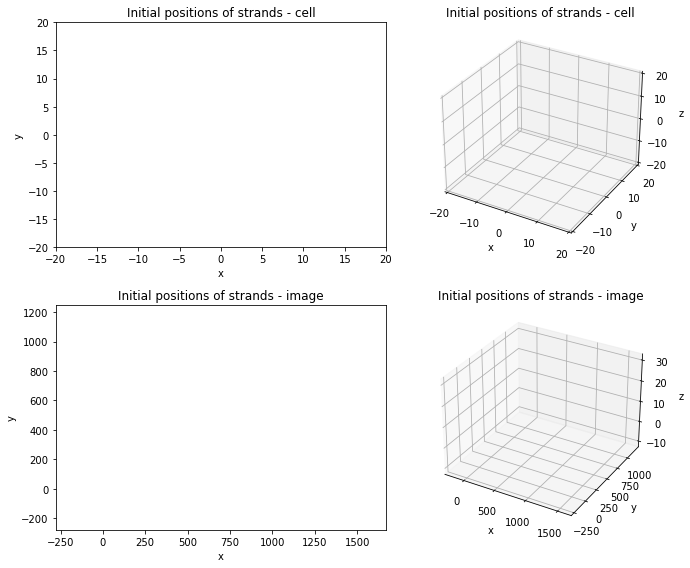

In [32]:
# attempt at writing DNA clumping with functions, currently not working due to issues passing/returning parameters.
# use_sphere?
use_sphere = True

def defining_parameters():
    # Radius of nucleus microns
    radius_nucleus = 2.0 
    radius_nucleus_min = 1.5 
    sig_radius_nucleus = 0.5 # what does sig stand for?

    # Radius of cell microns
    radius_cell = 10.0 
    radius_cell_min = 16.0 
    sig_radius_cell = 1.0 # sig?
    
    return radius_nucleus, radius_nucleus_min, sig_radius_nucleus, radius_cell, radius_cell_min, sig_radius_cell


def _2Dcell(radius_cell):
    # 2D graph of strand positions in cell
    ax2d_cell = fig.add_subplot(2, 2, 1)
    ax2d_cell.set_title("Initial positions of strands - cell")
    ax2d_cell.set_xlabel("x")
    ax2d_cell.set_ylabel("y")
    scale_cell = 2.0
    ax2d_cell.set_xlim(-scale_cell*radius_cell, scale_cell*radius_cell)
    ax2d_cell.set_ylim(-scale_cell*radius_cell, scale_cell*radius_cell)

def _3Dcell(radius_cell):
    # 3D graph of strand positions in cell
    ax3d_cell = fig.add_subplot(2, 2, 2, projection='3d')
    ax3d_cell.set_title("Initial positions of strands - cell")
    ax3d_cell.set_xlabel("x")
    ax3d_cell.set_ylabel("y")
    ax3d_cell.set_zlabel("z")
    scale_cell = 2.0
    ax3d_cell.set_xlim(-scale_cell*radius_cell, scale_cell*radius_cell)
    ax3d_cell.set_ylim(-scale_cell*radius_cell, scale_cell*radius_cell)
    ax3d_cell.set_zlim(-scale_cell*radius_cell, scale_cell*radius_cell)

def _2Dimage(n_columns, n_rows):
    # 2D graph of strand positions in image - how does image vary from cell?
    ax2d_pic = fig.add_subplot(2, 2, 3)
    ax2d_pic.set_title("Initial positions of strands - image")
    ax2d_pic.set_xlabel("x")
    ax2d_pic.set_ylabel("y")
    expand_pic = 0.2
    ax2d_pic.set_xlim(-expand_pic*n_columns, (1 + expand_pic)*n_columns)
    ax2d_pic.set_ylim(-expand_pic*n_columns, (1 + expand_pic)*n_rows)

def _3Dimage(n_columns, n_rows, radius_cell, depth):
    # 3D graph of strand positions in image
    ax3d_pic = fig.add_subplot(2, 2, 4, projection='3d')
    ax3d_pic.set_title("Initial positions of strands - image")
    ax3d_pic.set_xlabel("x")
    ax3d_pic.set_ylabel("y")
    ax3d_pic.set_zlabel("z")
    expand_pic = 0.2
    ax3d_pic.set_xlim(-expand_pic*n_columns, (1 + expand_pic)*n_columns)
    ax3d_pic.set_ylim(-expand_pic*n_columns, (1 + expand_pic)*n_rows)
    ax3d_pic.set_zlim(-(1 + expand_pic)*radius_cell, depth + (1 + expand_pic)*radius_cell)
    

def number_of_cells(radius_cell, radius_cell_min, sig_radius_cell, no_single_strands, color_tab):
    # Set up number of cells and their positions
    n_cells = 15
    x_cell = np.zeros(n_cells)
    y_cell = np.zeros(n_cells)
    z_cell = np.zeros(n_cells)
    
    # Image dimensions of pixels. Rows y coordinate, columns, x coordinate, depth z coordinate.
    n_rows = 1040 
    n_columns = 1392 
    depth = 20

    # Set location of cells
    if n_cells == 1:
        x_cell[0] = n_columns/2
        y_cell[0] = n_rows/2
        z_cell[0] = depth/2
    else:
        x_cell = np.random.uniform(0, n_columns, n_cells)
        y_cell = np.random.uniform(0, n_rows, n_cells)
        z_cell = np.random.uniform(0, depth, n_cells)

    for n_cell in range(0, n_cells):
        # Simulate uniform radial and phi initial distribution of strands
        radius_array = np.sqrt(np.random.uniform(0, max(np.random.normal(radius_cell, sig_radius_cell, 1),
                                                  radius_cell_min)**2, no_single_strands))
        phi_array = np.random.uniform(0, 2*np.pi, no_single_strands)
    
        # Determine initial x, y, z coordinates of strands (simulate uniform intial theta distribution if required)
        if use_sphere:
            theta_array = np.arccos(np.random.uniform(-1, 1, no_single_strands))
            x_array = x_cell[n_cell] + radius_array*np.sin(theta_array)*np.cos(phi_array)
            y_array = y_cell[n_cell] + radius_array*np.sin(theta_array)*np.sin(phi_array)
            z_array = z_cell[n_cell] + radius_array*np.cos(theta_array)
        else:
            x_array = x_cell[n_cell] + radius_array*np.cos(phi_array)
            y_array = y_cell[n_cell] + radius_array*np.sin(phi_array)
            z_array = x_cell[n_cell] + np.random.uniform(0, depth, no_single_strands)
    
        # Plot intial positions of all strands in image
        color_inds = (np.linspace(0, no_single_strands - 1, no_single_strands)%n_color_tab).astype(int) # ind - indices/index?
        ax2d_pic.scatter(x_array, y_array, color = color_tab[color_inds], s = 1.0)
        ax3d_pic.scatter(x_array, y_array, z_array, color = color_tab[color_inds], s = 1.0)
    
        if n_cell > 0:
            continue
    
        # Plot initial positions of strands in one cell 
        ax2d_cell.scatter(x_array - x_cell[n_cell], y_array - y_cell[n_cell], color = color_tab[color_inds], s = 10.0)
        ax3d_cell.scatter(x_array - x_cell[n_cell], y_array - y_cell[n_cell], 
                          z_array - z_cell[n_cell], color = color_tab[color_inds], s = 10.0)   
       
    return n_columns, n_rows, depth


defining_parameters()

# Color table for plots
n_color_tab = 8 # number of colours in use
color_tab = np.array(['r', 'orange', 'y', 'g', 'c', 'b', 'm', 'k'])
fig = plt.figure(figsize = (10, 8))

# Colors for plotting strands
colors = np.zeros(no_single_strands).astype(str)

number_of_cells(radius_cell, radius_cell_min, sig_radius_cell, no_single_strands, color_tab)
_2Dcell(radius_cell)
_3Dcell(radius_cell)
_2Dimage(n_columns, n_rows)
_3Dimage(n_columns, n_rows, radius_cell, depth)
plt.tight_layout()
plt.show()

**Motion of DNA in Agrose**  

In [ ]:
# temporarily moving date time calculations out of section

# can we call on datetime from strand length section for this?
then = date_time()
then

now = datetime.datetime.now()
print("Date and time ",str(now))
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

now = date_time()
now
print("Time since last check is",str(now - then))



Parameters used to descibe velocity in agarose
kB = 2.24
kC = 0.56
kL = 0.59
alpha = 1.34


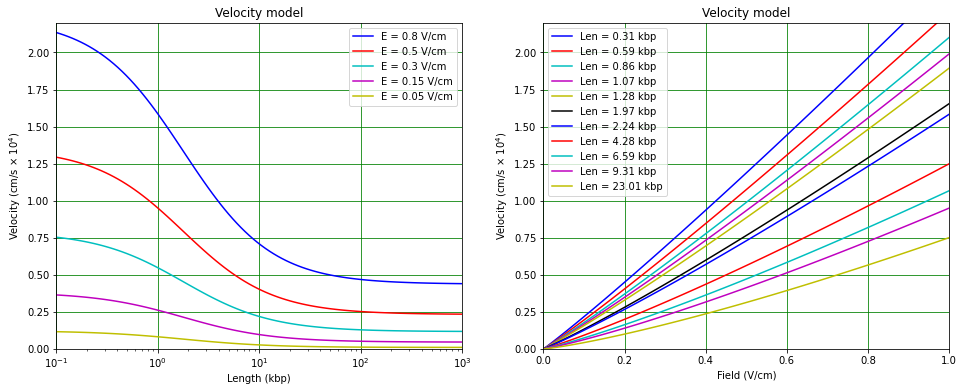

In [42]:
def velocity_in_agarose(length, electric_field):
    '''
    Parameters: L length of DNA strand (in kbp), E electric field (in V/cm) 
    Returns: velocity velocity in agarose (in cm/s * 10^4 or equivalently microns/s).
    '''
    if not hasattr(velocity_in_agarose, "kB"):
        # what is kB, kC, kL, alpha
        velocity_in_agarose.kB, velocity_in_agarose.kC, velocity_in_agarose.kL, velocity_in_agarose.alpha = 2.24, 0.56, 0.59, 1.34
        print("\nParameters used to descibe velocity in agarose")
        print("kB = {:.2f}".format(velocity_in_agarose.kB))
        print("kC = {:.2f}".format(velocity_in_agarose.kC))
        print("kL = {:.2f}".format(velocity_in_agarose.kL))
        print("alpha = {:.2f}".format(velocity_in_agarose.alpha))
    
    velocity = velocity_in_agarose.kB*electric_field/(1 + velocity_in_agarose.kC*length) + velocity_in_agarose.kL*electric_field**velocity_in_agarose.alpha
    
    return velocity

# Calculate fitted function values x direction
nPlot = 100
xBot = 0.1
xTop = 1000.0
xPlot = np.exp(np.linspace(np.log(xBot), np.log(xTop), nPlot))
nY = 5
yVals = np.array([0.05, 0.15, 0.3, 0.5, 0.8]) # V/cm

# Calculate fitted function values y direction
yBot = 0.0
yTop = 1.0
yPlot = np.linspace(yBot, yTop, nPlot)
nX = 11
xVals = np.array([0.31, 0.59, 0.86, 1.07, 1.28, 1.97, 2.24, 4.28, 6.59, 9.31, 23.01]) # kbp

# Plot data
nColTab = 6 # why only 6 data points, does this relate to fields?
colTab = ['b', 'r', 'c', 'm', 'y', 'k']

# Velocity-length graph
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Velocity model')
ax.set_xlabel('Length (kbp)')
ax.set_ylabel('Velocity (cm/s $\\times$ $10^4$)')
nCol = 0

for plot in range(nY, 0, -1):
    fitPlotX = velocity_in_agarose(xPlot, yVals[plot - 1]*np.ones(nPlot))
    ax.plot(xPlot, fitPlotX, linestyle = '-', color = colTab[nCol], label = "E = " + str(yVals[plot - 1]) + " V/cm")
    nCol += 1
    if nCol > nColTab - 1:
        nCol = 0
        
ax.set_xlim(xBot, xTop)
ax.set_ylim(0, 2.2)
ax.set_xscale('log')
ax.grid(color = 'g')
ax.legend()    

# Velocity-field graph
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Velocity model')
ax.set_xlabel('Field (V/cm)')
ax.set_ylabel('Velocity (cm/s $\\times$ $10^4$)')
nCol = 0

for plot in range(0, nX):
    fitPlotY = velocity_in_agarose(xVals[plot]*np.ones(nPlot), yPlot) # (length, electric_field)
    ax.plot(yPlot, fitPlotY, linestyle = '-', color = colTab[nCol], label = "Len = " + str(xVals[plot]) + " kbp")
    nCol += 1
    
    if nCol > nColTab - 1:
        nCol = 0
        
ax.set_xlim(yBot, yTop)
ax.set_ylim(0, 2.2)
ax.grid(color = 'g')
ax.legend()    

plt.savefig("FitPlot.png")
plt.show()